In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
from keras import applications
import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "car_data/car_data/train"
tstdirectory = "car_data/car_data/test"
#DIVIDING THE TRAIN AND TEST FOLDER TO train_dataset and validation_dataset
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(tstdirectory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 8144 files belonging to 196 classes.
Found 8041 files belonging to 196 classes.


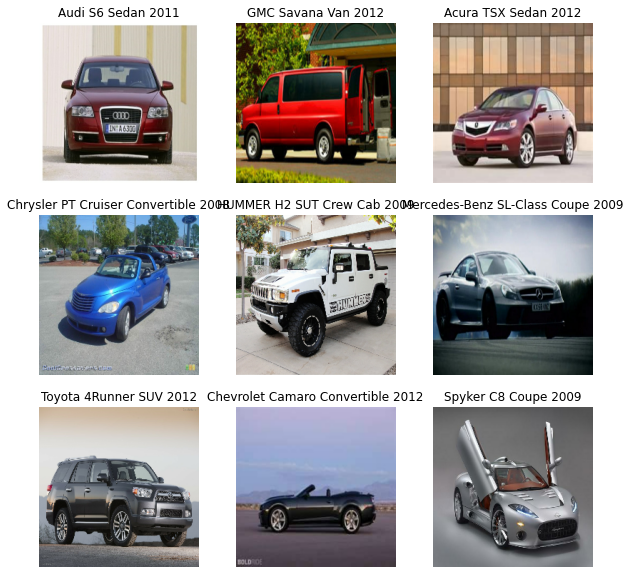

In [4]:
#PLOTTING THE CAR WITH THEIR LABELS
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
#TensorFlow Hub's convention for image models is to expect float inputs in the [0, 1] range, use tf.keras.layers.Rescaling preprocessing layer to achieve this.
normalisation_layer=tf.keras.layers.Rescaling(1./255)
train_dataset=train_dataset.map(lambda x,y:(normalisation_layer(x),y))
validation_dataset=validation_dataset.map(lambda x,y:(normalisation_layer(x),y))

In [9]:
#As part of the training process, we'll need to read data from our directories, 
#but we don't want to make our model wait for this data, so autotune allows us to fetch the data dynamically.
AUTOTUNE=tf.data.AUTOTUNE
train_dataset=train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset=train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
#32 is our batchsize and (224,224,3) is our image size

(32, 224, 224, 3)
(32,)


In [7]:
#Using tensorflow hub to get the model
mobileNet_v3="https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"
classifier_model=mobileNet_v3
classifier=tf.keras.Sequential([
    hub.KerasLayer(classifier_model,input_shape=IMG_SIZE+(3,))
])
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

255/255 [==============================] - 279s 1s/step


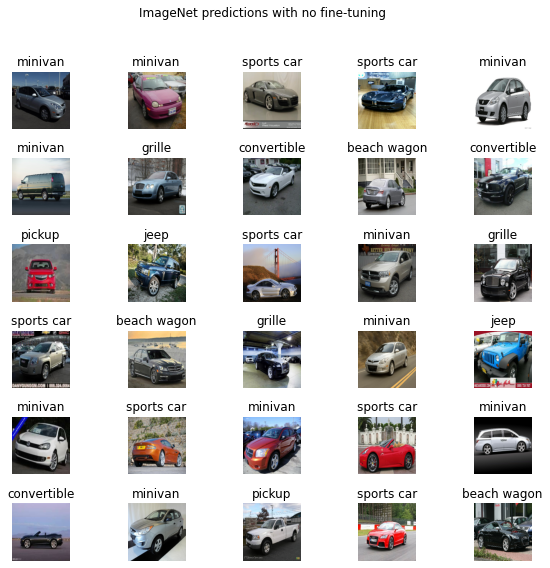

In [12]:
result_batch = classifier.predict(train_dataset)
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions with no fine-tuning")

In [13]:
#Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. 
#Use the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer
feature_extractor_model=mobileNet_v3
ft_extractor_layer=hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224,224,3),
    trainable=False #set to false so that we can freeze the weights and paramters
)

In [14]:
NUM_CLASSES = len(class_names)
#To complete the model, wrap the feature extractor layer in a tf.keras.
#Sequential model and add a fully-connected layer for classification
model = tf.keras.Sequential([
  ft_extractor_layer,
  tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5508713   
                                                                 
 dense (Dense)               (None, 196)               196392    
                                                                 
Total params: 5,705,105
Trainable params: 196,392
Non-trainable params: 5,508,713
_________________________________________________________________


In [15]:
#Compiling the model
model.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)

In [16]:
#training the model with 10 epochs
history=model.fit(train_dataset,epochs=10,validation_data=validation_dataset)

Epoch 1/10
255/255 [==============================] - 608s 2s/step - loss: 3.9582 - accuracy: 0.1601 - val_loss: 2.2938 - val_accuracy: 0.4666
Epoch 2/10
255/255 [==============================] - 539s 2s/step - loss: 2.2420 - accuracy: 0.4611 - val_loss: 1.5447 - val_accuracy: 0.6449
Epoch 3/10
255/255 [==============================] - 491s 2s/step - loss: 1.6159 - accuracy: 0.6201 - val_loss: 1.1503 - val_accuracy: 0.7468
Epoch 4/10
255/255 [==============================] - 489s 2s/step - loss: 1.2379 - accuracy: 0.7274 - val_loss: 0.8962 - val_accuracy: 0.8173
Epoch 5/10
255/255 [==============================] - 466s 2s/step - loss: 0.9780 - accuracy: 0.8000 - val_loss: 0.7168 - val_accuracy: 0.8663
Epoch 6/10
255/255 [==============================] - 448s 2s/step - loss: 0.7869 - accuracy: 0.8562 - val_loss: 0.5832 - val_accuracy: 0.9042
Epoch 7/10
255/255 [==============================] - 441s 2s/step - loss: 0.6410 - accuracy: 0.8969 - val_loss: 0.4803 - val_accuracy: 0.9278

Text(0.5, 1.0, 'Training and validation loss')

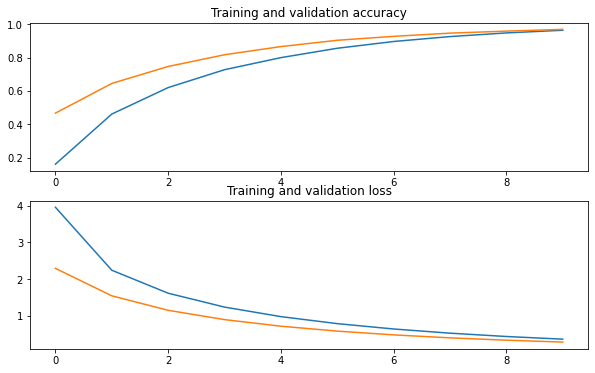

In [49]:
#plotting the accuracy and loss of training and validation
fig = plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Training and validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Training and validation loss')